Performance Summary: {'Total Return (%)': np.float64(272.72), 'Sharpe': np.float64(0.87), 'Max Drawdown (%)': -25.3, 'Num Entries': 18, 'Win Rate (%)': np.float64(53.2)}


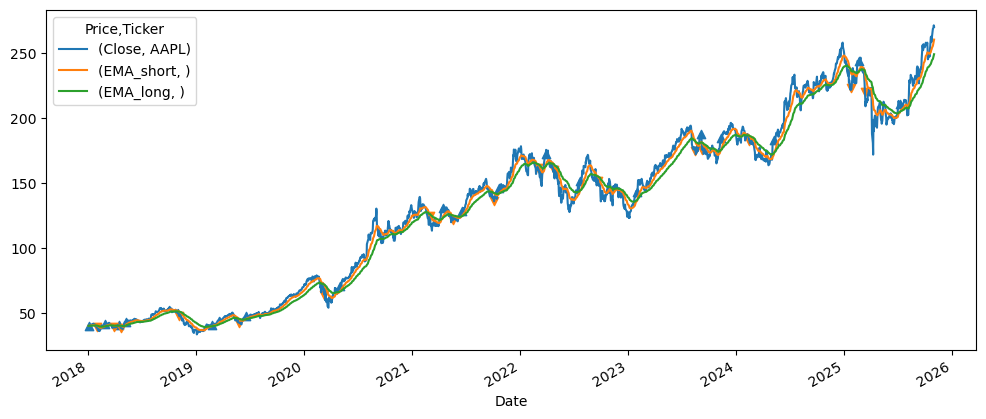

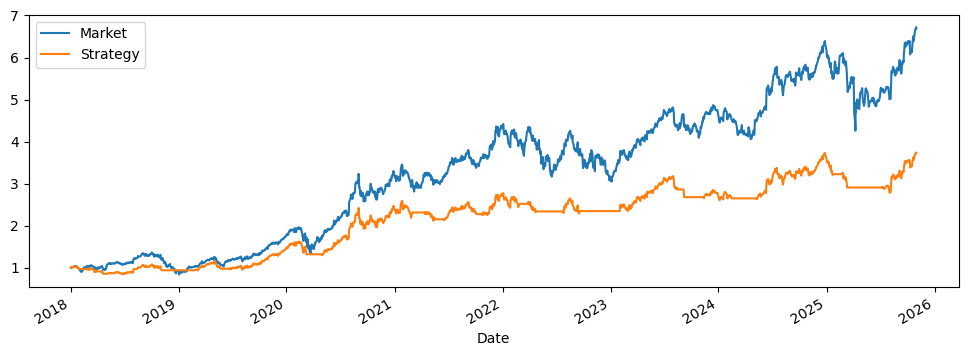

Saved results to ema_strategy_results.csv


In [8]:
# ema_strategy_realtime.py
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd.min()

def run_ema_strategy(ticker="AAPL", start="2020-01-01", end=None, short_span=20, long_span=50):
    data = yf.download(ticker, start=start, end=end, progress=False,auto_adjust=True)
    data = data.dropna()
    data['EMA_short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
    data['EMA_long'] = data['Close'].ewm(span=long_span, adjust=False).mean()
    data['Signal'] = 0
    data.loc[data['EMA_short'] > data['EMA_long'], 'Signal'] = 1
    data['Position'] = data['Signal'].diff()
    data['Strategy_Position'] = data['Signal'].shift(1).fillna(0)
    data['Market_Return'] = data['Close'].pct_change().fillna(0)
    data['Strategy_Return'] = data['Strategy_Position'] * data['Market_Return']
    cumulative_market = (1 + data['Market_Return']).cumprod()
    cumulative_strategy = (1 + data['Strategy_Return']).cumprod()
    daily_ret = data['Strategy_Return'].mean()
    daily_vol = data['Strategy_Return'].std()
    sharpe = (daily_ret / daily_vol) * sqrt(252) if daily_vol != 0 else np.nan
    total_return = cumulative_strategy.iloc[-1] - 1
    max_dd = max_drawdown(cumulative_strategy)
    summary = {
        "Total Return (%)": round(total_return*100,2),
        "Sharpe": round(sharpe,2),
        "Max Drawdown (%)": round(max_dd*100,2),
        "Num Entries": int((data['Position']==1).sum()),
        "Win Rate (%)": round(100*(data.loc[data['Strategy_Return']>0,'Strategy_Return'].count()/data['Strategy_Return'].replace(0,np.nan).count()),2)
    }
    return data, cumulative_market, cumulative_strategy, summary

if __name__ == "__main__":
    ticker = "AAPL"          # change ticker
    data, cum_market, cum_strat, summary = run_ema_strategy(ticker=ticker, start="2018-01-01")
    print("Performance Summary:", summary)
    data[['Close','EMA_short','EMA_long']].plot(figsize=(12,5))
    plt.scatter(data[data['Position']==1].index, data[data['Position']==1]['Close'], marker='^')
    plt.scatter(data[data['Position']==-1].index, data[data['Position']==-1]['Close'], marker='v')
    plt.show()
    cum = pd.DataFrame({"Market": cum_market, "Strategy": cum_strat})
    cum.plot(figsize=(12,4))
    plt.show()
    data.to_csv("ema_strategy_results.csv")
    print("Saved results to ema_strategy_results.csv")


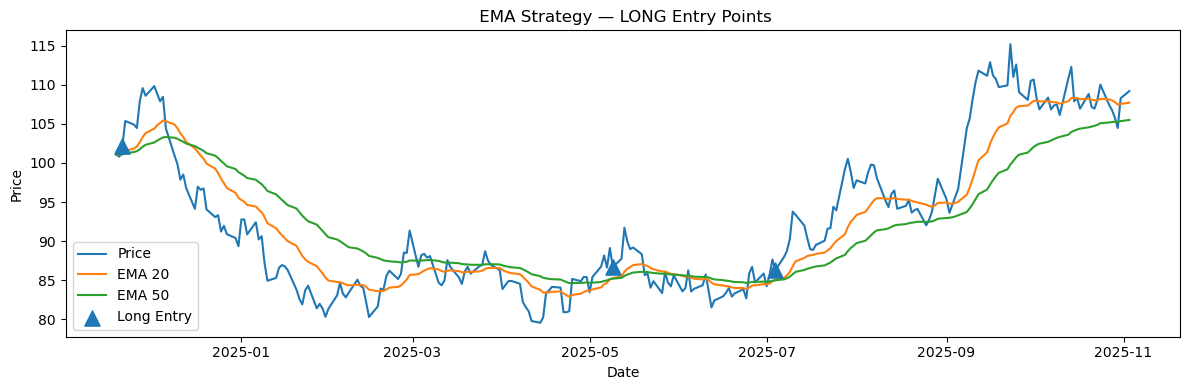

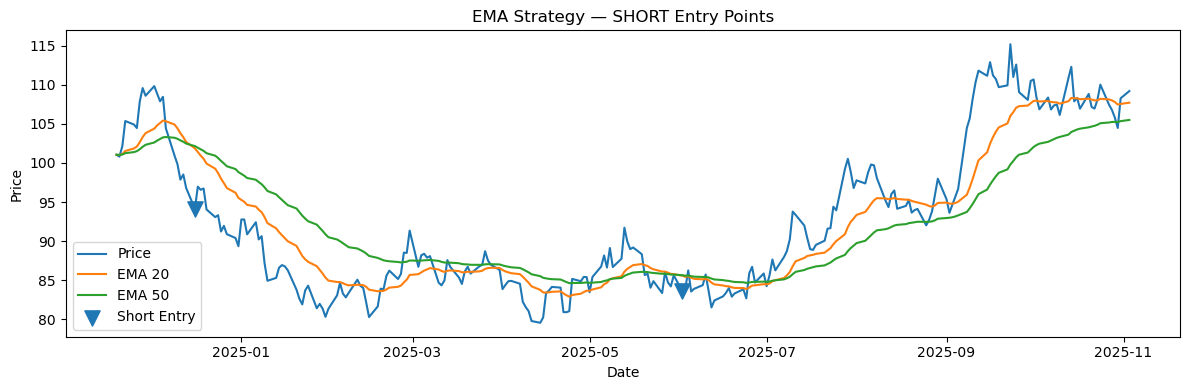

                 Close       EMA20       EMA50  Signal  Position
2024-11-19  101.038787  101.038787  101.038787      -1       NaN
2024-11-20  100.800083  101.016053  101.029426      -1       0.0
2024-11-21  102.155172  101.124541  101.073573       1       2.0
2024-11-22  105.356891  101.527622  101.241546       1       0.0
2024-11-25  104.906606  101.849430  101.385274       1       0.0
2024-11-26  104.458279  102.097891  101.505784       1       0.0
2024-11-27  107.853303  102.646026  101.754706       1       0.0
2024-11-28  109.565297  103.305004  102.061004       1       0.0
2024-11-29  108.584775  103.807839  102.316838       1       0.0
2024-12-02  109.813383  104.379796  102.610820       1       0.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Helper: Max Drawdown --------
def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd.min()

# -------- Generate Synthetic Price Data (Short Timeframe) --------
np.random.seed(42)
n = 250   # shorter timeframe
dates = pd.bdate_range(end=pd.Timestamp.today(), periods=n)

mu = 0.0004
sigma = 0.02
returns = np.random.normal(loc=mu, scale=sigma, size=n)
price = 100 * np.exp(np.cumsum(returns))

df = pd.DataFrame({"Close": price}, index=dates)

# -------- Compute EMAs --------
short_ema = 20
long_ema = 50

df[f"EMA{short_ema}"] = df['Close'].ewm(span=short_ema, adjust=False).mean()
df[f"EMA{long_ema}"] = df['Close'].ewm(span=long_ema, adjust=False).mean()

# -------- Generate Signals --------
df['Signal'] = np.where(df[f"EMA{short_ema}"] > df[f"EMA{long_ema}"], 1, -1)
df['Position'] = df['Signal'].diff()

# Position legend:
# +2 or +1 = enter long
# -2 or -1 = enter short

# -------- Plot LONG Entries --------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Close'], label='Price')
plt.plot(df.index, df[f"EMA{short_ema}"], label=f'EMA {short_ema}')
plt.plot(df.index, df[f"EMA{long_ema}"], label=f'EMA {long_ema}')

long_entries = df[(df['Position'] == 2) | (df['Position'] == 1)]
plt.scatter(long_entries.index, long_entries['Close'], marker='^', s=120, label='Long Entry', zorder=5)

plt.title(" EMA Strategy — LONG Entry Points")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

# -------- Plot SHORT Entries --------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Close'], label='Price')
plt.plot(df.index, df[f"EMA{short_ema}"], label=f'EMA {short_ema}')
plt.plot(df.index, df[f"EMA{long_ema}"], label=f'EMA {long_ema}')

short_entries = df[(df['Position'] == -2) | (df['Position'] == -1)]
plt.scatter(short_entries.index, short_entries['Close'], marker='v', s=120, label='Short Entry', zorder=5)

plt.title("EMA Strategy — SHORT Entry Points")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

# -------- Display First Rows --------
print(df.head(10))
